In [2]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

Total number of categories: 151
Total number of images in dataset: 22656


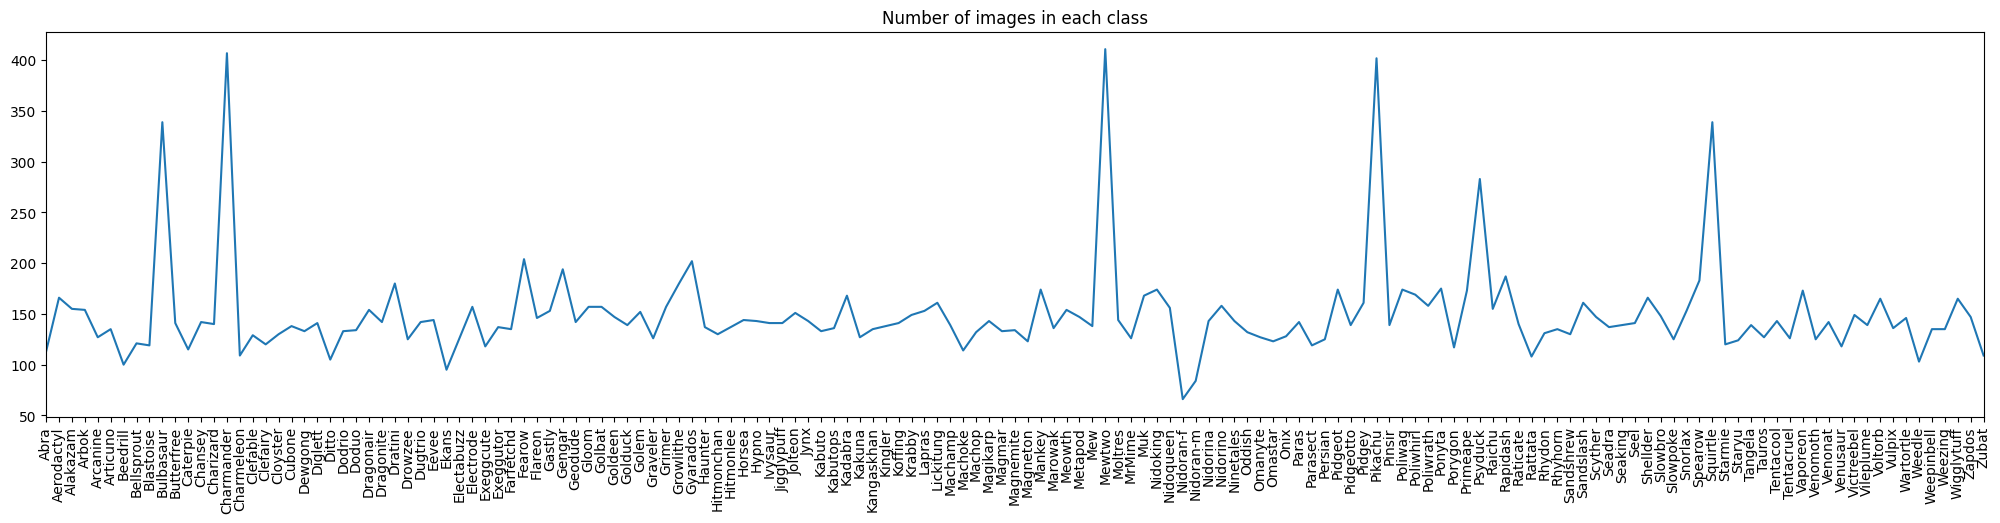

In [3]:
# A little bit of data exploration
path = './PokemonData' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [4]:
# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

[('Mewtwo', 411), ('Charmander', 407), ('Pikachu', 402), ('Bulbasaur', 339), ('Squirtle', 339)]
['Mewtwo', 'Charmander', 'Pikachu', 'Bulbasaur', 'Squirtle']


In [5]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

./PokemonData\Mewtwo\ed9eb0e7d3494c6992e06196f5b7cc05.svg [ERROR] can't read the file
DONE


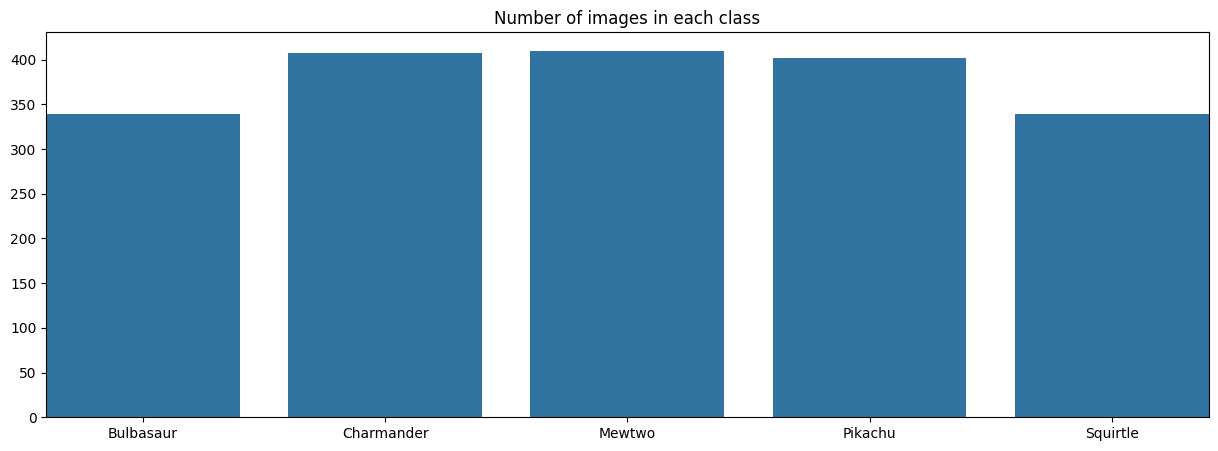

In [6]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [7]:
# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

In [12]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
# img = X[600]
# img = img.reshape([-1, 96, 96, 3])

# i = 0
# fig = plt.figure(figsize = (18, 8))

# for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
#     fig.add_subplot(2, 5, i+1)
#     plt.imshow(np.squeeze(flow[:, :, ::-1]))
#     plt.axis('off')
#     i += 1
#     if i >= 10:
#         break

In [13]:
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(imbalanced), activation = 'softmax'))

# model.summary()
checkpoint = ModelCheckpoint('../working/best_model.keras', verbose = 1, monitor = 'val_accuracy', save_best_only = True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size = 32), epochs = 100, validation_data = [X_test, y_test],
                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.4254 - loss: 1.8568
Epoch 1: val_accuracy improved from -inf to 0.21053, saving model to ../working/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 794ms/step - accuracy: 0.4285 - loss: 1.8464 - val_accuracy: 0.2105 - val_loss: 2.4613
Epoch 2/100
 1/47 ━━━━━━━━━━━━━━━━━━━━ 39s 861ms/step - accuracy: 0.5312 - loss: 1.3652
Epoch 2: val_accuracy improved from 0.21053 to 0.21579, saving model to ../working/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5312 - loss: 0.6971 - val_accuracy: 0.2158 - val_loss: 2.6414
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6919 - loss: 1.0196
Epoch 3: val_accuracy did not improve from 0.21579
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 876ms/step - accuracy: 0.6921 - loss: 1.0182 - val_accuracy: 0.1789 - val_loss: 7.8945
Epoch 4/100
 1/47 ━━━━━━━━━━━━━━━━━━━━ 42s 929ms/step - accuracy: 0.8125 - loss: 0.6673
Epoch 4: val_accuracy did not improve from 0.21579

Text(0.5, 1.0, 'loss')

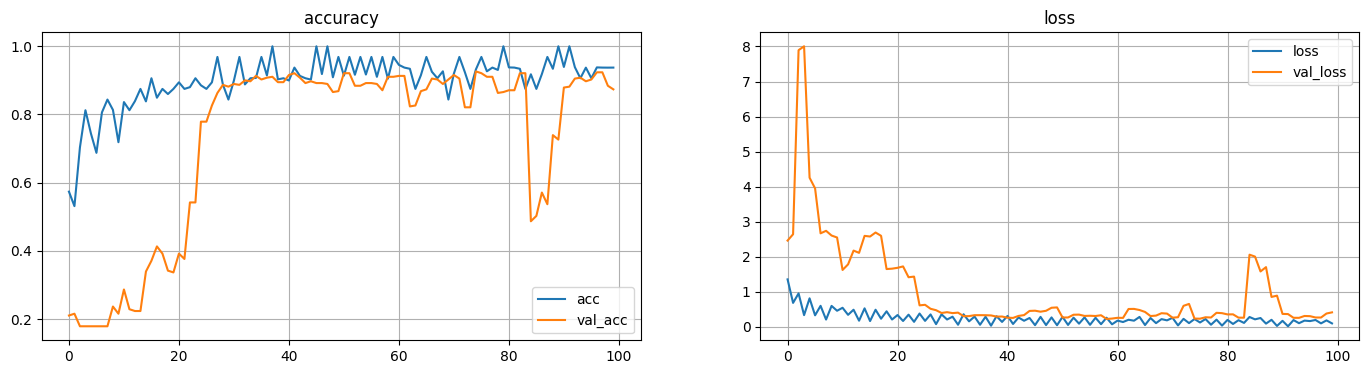

In [14]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [27]:
# Saving the entire model
model.save('../working/best_model.keras', include_optimizer=False)



In [28]:
from keras.models import load_model

# Load the model from the saved file
loaded_model = load_model('../working/best_model.keras', compile=False)

In [32]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/6087/2437349-pikachu.png',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

In [39]:
import cv2
import os

# Define the paths to your local directories containing the images
mewtwo_dir = './pokemon_test/mewtwo'
pikachu_dir = './pokemon_test/pikachu'
charmander_dir = './pokemon_test/charmander'
bulbasaur_dir = './pokemon_test/bulbasaur'
squirtle_dir = './pokemon_test/squirtle'

# Function to load images from a directory and append them to a list with labels
def load_images_from_dir(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Load images and labels for each Pokémon
mewtwo_images, mewtwo_labels = load_images_from_dir(mewtwo_dir, label=0)
pikachu_images, pikachu_labels = load_images_from_dir(pikachu_dir, label=1)
charmander_images, charmander_labels = load_images_from_dir(charmander_dir, label=2)
bulbasaur_images, bulbasaur_labels = load_images_from_dir(bulbasaur_dir, label=3)
squirtle_images, squirtle_labels = load_images_from_dir(squirtle_dir, label=4)

# Combine all images and labels into a single list
all_images = mewtwo_images + pikachu_images + charmander_images + bulbasaur_images + squirtle_images
all_labels = mewtwo_labels + pikachu_labels + charmander_labels + bulbasaur_labels + squirtle_labels

# Now you can use 'all_images' and 'all_labels' for your tasks


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


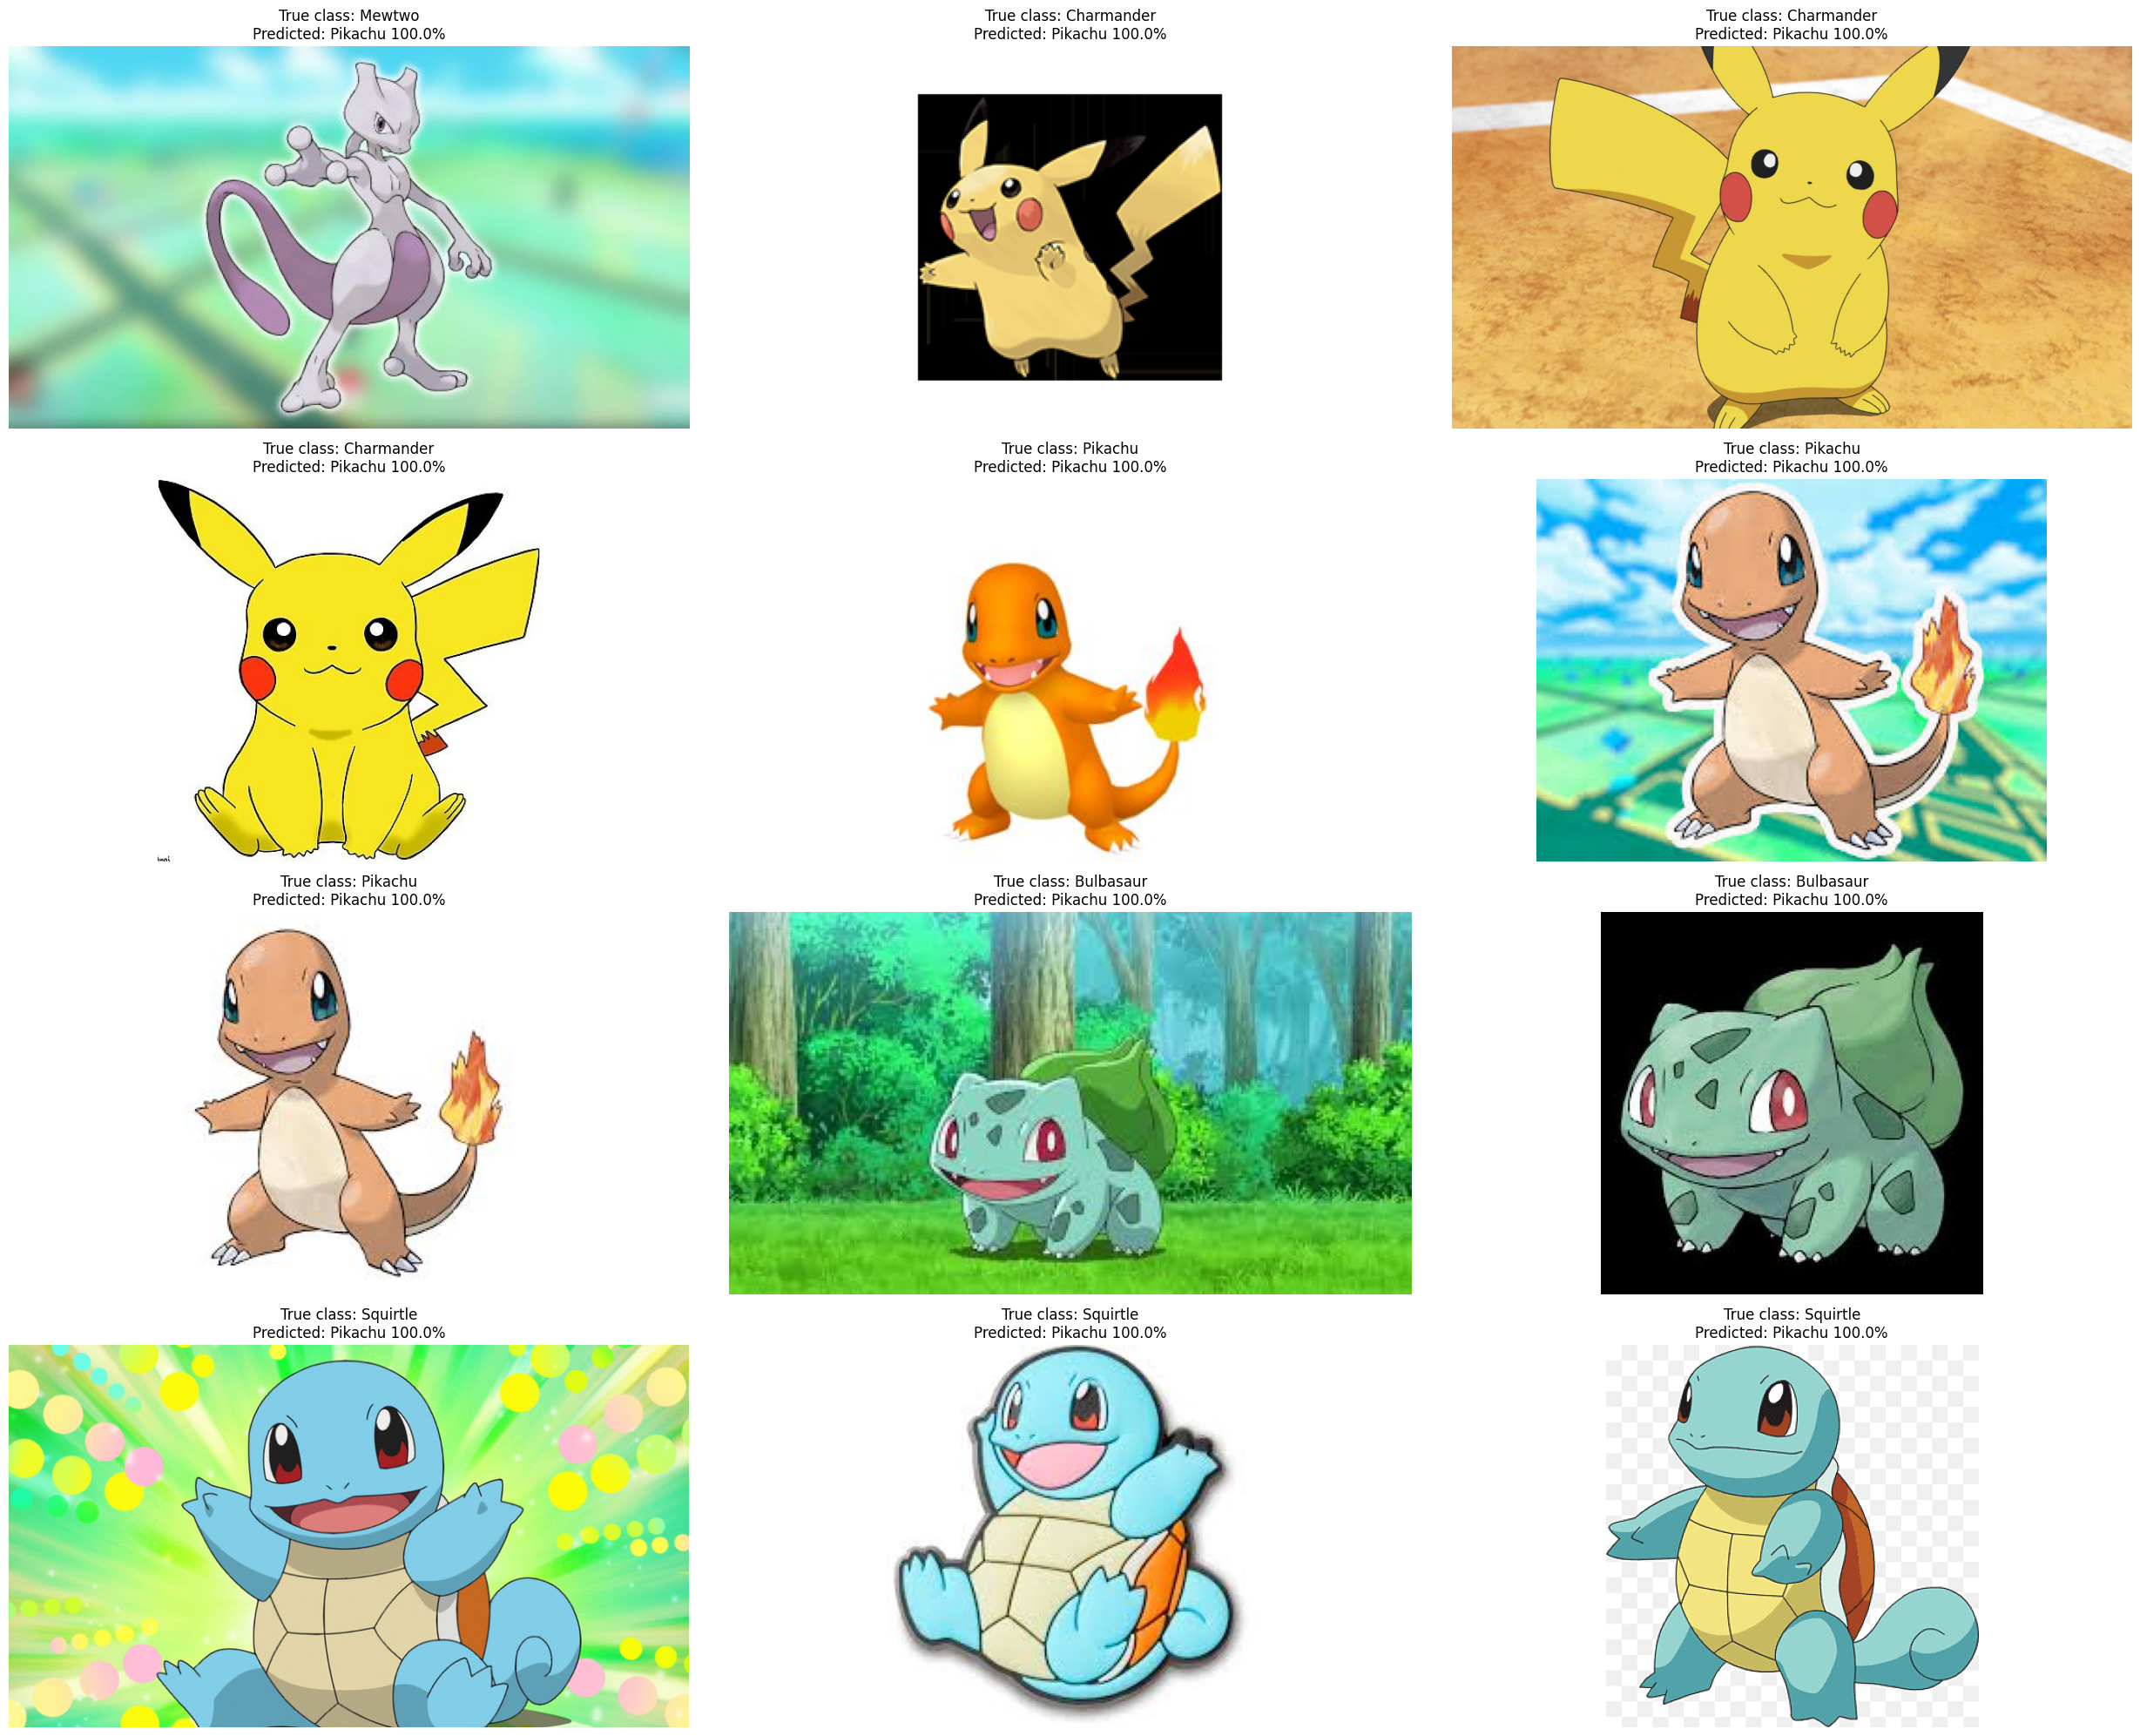

In [41]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 25))

for i, j in enumerate(zip(all_images, all_labels)): # i - for subplots
    orig = j[0] # Original, not resized image
    label = j[1] # Label for that image
    
    image = cv.resize(orig, (96, 96)) # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0 # Reshape and scale resized image
    preds = model.predict(image) # Predicting image
    pred_class = np.argmax(preds) # Defining predicted class
    
    true_label = f'True class: {imbalanced[label]}'
    pred_label = f'Predicted: {imbalanced[pred_class]} {round(preds[0][pred_class] * 100, 2)}%'
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}')
    plt.axis('off')
    
plt.tight_layout()
